In [ ]:
#Created by wly
#Saturday March 7, 2020

In [ ]:
#This notebook runs in Google Colab Environment

In [0]:
! git clone https://github.com/fowill/captcha_torch.git

Cloning into 'captcha_torch'...
remote: Enumerating objects: 10008, done.
remote: Counting objects: 100% (10008/10008), done.
remote: Compressing objects: 100% (10007/10007), done.
remote: Total 10008 (delta 1), reused 10008 (delta 1), pack-reused 0
Receiving objects: 100% (10008/10008), 47.39 MiB | 49.22 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision.transforms import Compose, ToTensor

import numpy as np
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
from PIL import Image

In [0]:
source = [str(i) for i in range(0, 10)]
alphabet = ''.join(source) #Only consider captchas in nubmber forms (0-9)

In [0]:
#Step1:load the data

def img_loader(img_path): #return an img converted to RGB form
    img = Image.open(img_path)
    return img.convert('RGB')

def make_dataset(data_path, alphabet, num_class, num_char): #return (img's path, img's one-hot label)
    img_names = os.listdir(data_path)
    samples = []
    for img_name in img_names:
        if img_name.endswith('.png'):
            img_path = os.path.join(data_path, img_name)
            target_str = img_name.split('_')[1][:4]
            assert len(target_str) == num_char
            target = []
            for char in target_str:
                vec = [0] * num_class
                vec[alphabet.find(char)] = 1
                target += vec
            samples.append((img_path, target))
    return samples  

class CaptchaData(Dataset): #A subclass of torch.utils.data.Dataset
    def __init__(self, data_path, num_class=10, num_char=4, 
                 transform=None, target_transform=None, alphabet=alphabet):
        super(Dataset, self).__init__()
        self.data_path = data_path
        self.num_class = num_class
        self.num_char = num_char
        self.transform = transform
        self.target_transform = target_transform
        self.alphabet = alphabet
        self.samples = make_dataset(self.data_path, self.alphabet, 
                                    self.num_class, self.num_char)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index): #__getitem__ method provides class a index like lists
        img_path, target = self.samples[index]
        img = img_loader(img_path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, torch.Tensor(target)  #return a img data and its one-hot label

In [0]:
#Step2 Create a CNN
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self, num_class=10, num_char=4):
        super(CNN, self).__init__()
        self.num_class = num_class
        self.num_char = num_char
        self.conv = nn.Sequential(  
                #batch*3*180*100
                nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=(1, 1)),
                nn.MaxPool2d(2,2), #size=2,stride=2,which means no overlap between pools
                nn.BatchNorm2d(num_features=16), #use batchnorm to accelerate the training
                nn.ReLU(),#use ReLu to add non-linear factor to cnn model
                #batch*16*90*50
                nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=(1, 1)),
                nn.MaxPool2d(2,2),
                nn.BatchNorm2d(num_features=64),
                nn.ReLU(),
                #batch*64*45*25
                nn.Conv2d(in_channels=64, out_channels=512, kernel_size=3, padding=(1, 1)),
                nn.MaxPool2d(2,2),
                nn.BatchNorm2d(num_features=512),
                nn.ReLU(),
                #batch*512*22*12
                nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=(1, 1)),
                nn.MaxPool2d(2,2),
                nn.BatchNorm2d(num_features=512),
                nn.ReLU(),
                #batch*512*11*6
                )
        self.fc = nn.Linear(in_features=512*11*6, out_features=self.num_class*self.num_char)
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 512*11*6)
        x = self.fc(x)
        return x

In [0]:
#Step3 Training

batch_size = 128
base_lr = 0.001
max_epoch = 40
model_path = './checkpoints/model.pth'
restor = False

if not os.path.exists('./checkpoints'):
    os.mkdir('./checkpoints')

def calculat_acc(output, target):
    output, target = output.view(-1, 10), target.view(-1, 10)
    output = nn.functional.softmax(output, dim=1)
    output = torch.argmax(output, dim=1) #torch.argmax() returns the index of the max element of a iterable object
    target = torch.argmax(target, dim=1)
    output, target = output.view(-1, 4), target.view(-1, 4)
    correct_list = []
    for i, j in zip(target, output):
        if torch.equal(i, j):
            correct_list.append(1)
        else:
            correct_list.append(0)
    acc = sum(correct_list) / len(correct_list)
    return acc

def train():
    transforms = Compose([ToTensor()])
    train_dataset = CaptchaData('./captcha_torch/data/train', transform=transforms)
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, 
                             shuffle=True, drop_last=True)
    test_data = CaptchaData('./captcha_torch/data/test', transform=transforms)
    test_data_loader = DataLoader(test_data, batch_size=batch_size, 
                                  num_workers=0, shuffle=True, drop_last=True)
    cnn = CNN()
    if torch.cuda.is_available():
        cnn.cuda() #moves all model parameters and buffers to the GPU
    if restor:
        cnn.load_state_dict(torch.load(model_path))
    
    optimizer = torch.optim.Adam(cnn.parameters(), lr=base_lr)
    criterion = nn.MultiLabelSoftMarginLoss()
    
    for epoch in range(max_epoch):
        start_ = time.time()
        
        loss_history = []
        acc_history = []
        cnn.train() #set the model in train model
        for img, target in train_data_loader:
            img = Variable(img)
            target = Variable(target)
            if torch.cuda.is_available():
                img = img.cuda()
                target = target.cuda()
            output = cnn(img)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            acc = calculat_acc(output, target)
            acc_history.append(acc)
            loss_history.append(loss)
        print('train_loss: {:.4}|train_acc: {:.4}'.format(
                torch.mean(torch.Tensor(loss_history)),
                torch.mean(torch.Tensor(acc_history)),
                ))
        
        loss_history = []
        acc_history = []
        cnn.eval() #set the model in evaluate model
        for img, target in test_data_loader:
            img = Variable(img)
            target = Variable(target)
            if torch.cuda.is_available():
                img = img.cuda()
                target = target.cuda()
            output = cnn(img)
            
            acc = calculat_acc(output, target)
            acc_history.append(acc)
            loss_history.append(float(loss))
        print('test_loss: {:.4}|test_acc: {:.4}'.format(
                torch.mean(torch.Tensor(loss_history)),
                torch.mean(torch.Tensor(acc_history)),
                ))
        print('epoch: {}|time: {:.4f}'.format(epoch, time.time()-start_))
        torch.save(cnn.state_dict(), model_path)

if __name__=="__main__":
    train()
    pass

train_loss: 0.4919|train_acc: 0.00063
test_loss: 0.3191|test_acc: 0.001563
epoch: 0|time: 20.8694
train_loss: 0.2731|train_acc: 0.0315
test_loss: 0.2139|test_acc: 0.02396
epoch: 1|time: 20.7337
train_loss: 0.1539|train_acc: 0.3083
test_loss: 0.1032|test_acc: 0.4031
epoch: 2|time: 20.6404
train_loss: 0.08298|train_acc: 0.5842
test_loss: 0.08412|test_acc: 0.5948
epoch: 3|time: 20.5470
train_loss: 0.05156|train_acc: 0.7463
test_loss: 0.04859|test_acc: 0.6589
epoch: 4|time: 20.5215
train_loss: 0.03111|train_acc: 0.8713
test_loss: 0.03627|test_acc: 0.6724
epoch: 5|time: 20.4045
train_loss: 0.01718|train_acc: 0.957
test_loss: 0.01746|test_acc: 0.7359
epoch: 6|time: 20.4615
train_loss: 0.009326|train_acc: 0.9897
test_loss: 0.007915|test_acc: 0.7922
epoch: 7|time: 20.4016
train_loss: 0.003969|train_acc: 0.9991
test_loss: 0.003773|test_acc: 0.8115
epoch: 8|time: 20.4160
train_loss: 0.001916|train_acc: 1.0
test_loss: 0.001715|test_acc: 0.8307
epoch: 9|time: 20.3860
train_loss: 0.001044|train_acc

pred: 7809
true: 7809


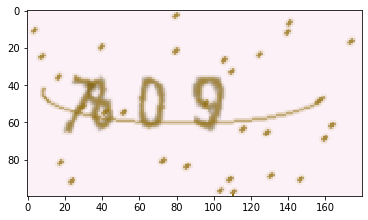

pred: 6334
true: 6334


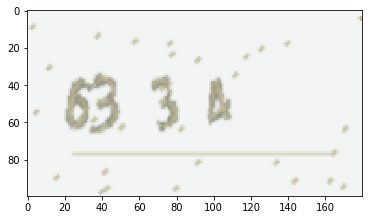

pred: 0000
true: 0007


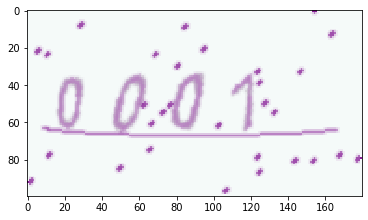

pred: 7138
true: 7138


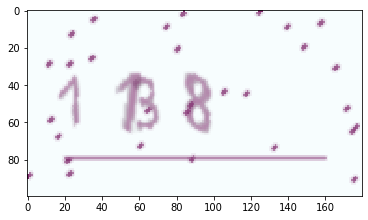

pred: 9111
true: 9112


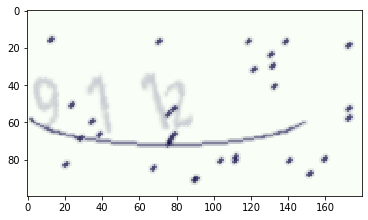

pred: 8256
true: 8256


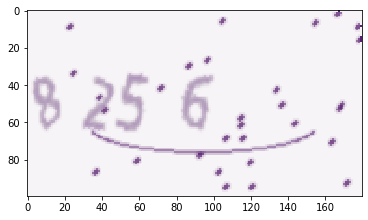

pred: 4395
true: 4395


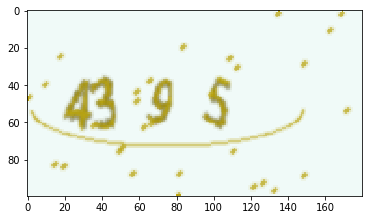

pred: 7010
true: 7010


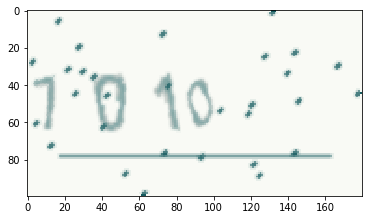

pred: 2080
true: 2080


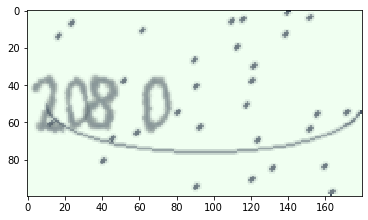

pred: 1443
true: 1443


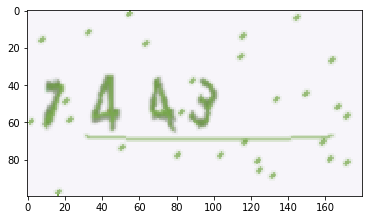

pred: 6939
true: 6939


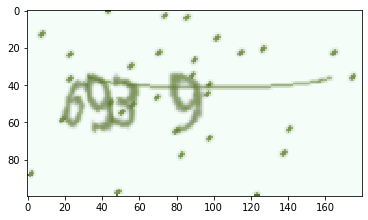

pred: 2312
true: 2312


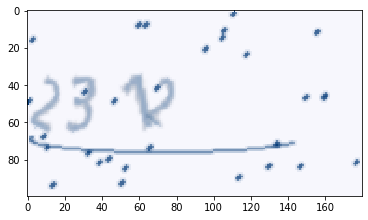

pred: 3397
true: 3397


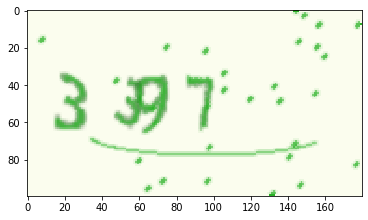

pred: 7614
true: 7614


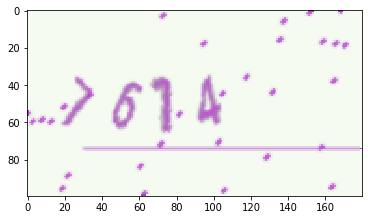

pred: 4700
true: 4700


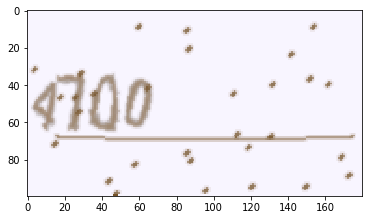

pred: 0012
true: 0012


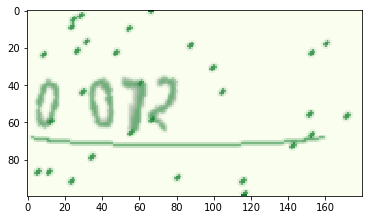

pred: 0405
true: 0405


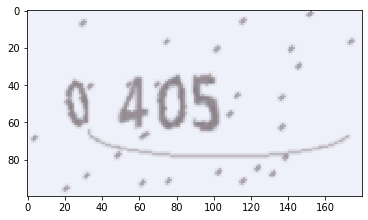

pred: 7900
true: 7890


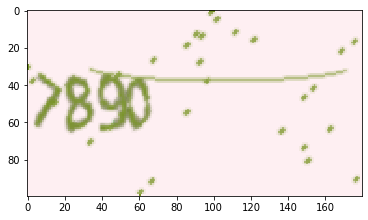

pred: 8559
true: 8599


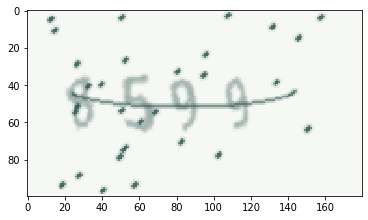

pred: 7666
true: 7636


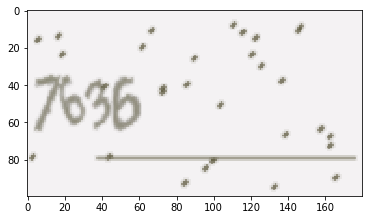

pred: 0155
true: 0715


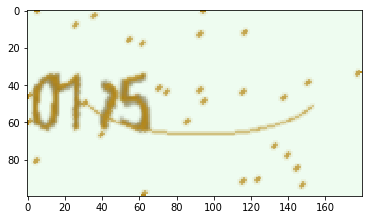

pred: 7593
true: 7593


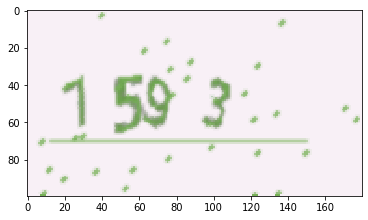

pred: 7505
true: 7505


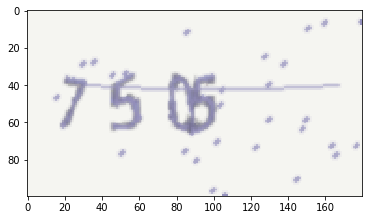

pred: 9684
true: 9684


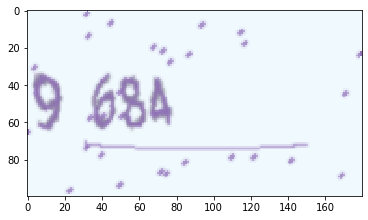

pred: 9548
true: 9548


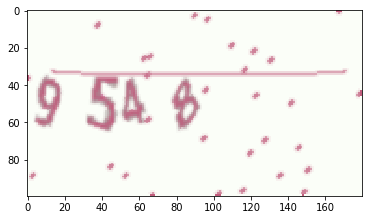

pred: 5952
true: 5952


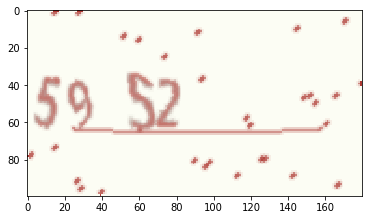

pred: 0656
true: 0656


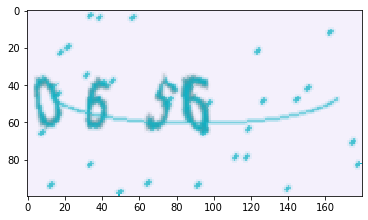

pred: 7911
true: 7911


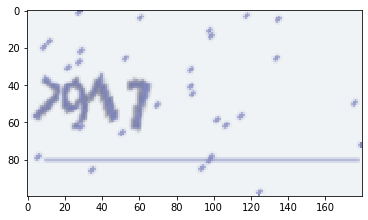

pred: 4246
true: 4246


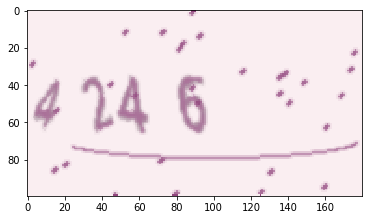

pred: 0919
true: 0919


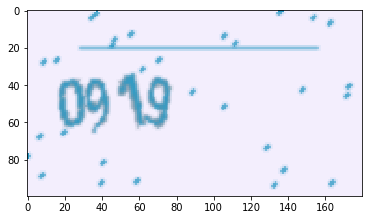

pred: 6469
true: 6469


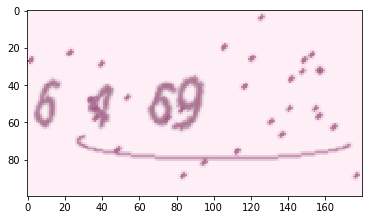

pred: 5337
true: 5367


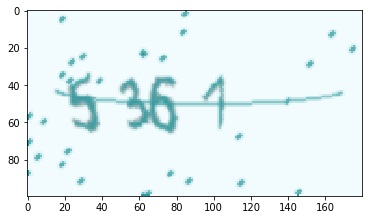

pred: 4416
true: 4416


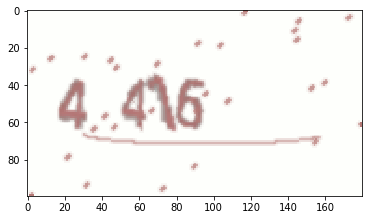

pred: 5094
true: 5094


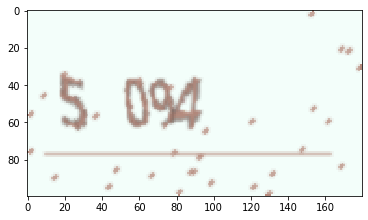

pred: 5923
true: 5923


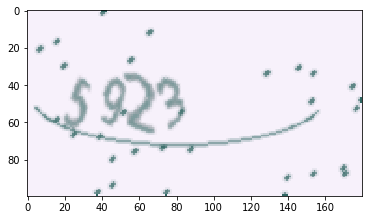

pred: 1006
true: 1016


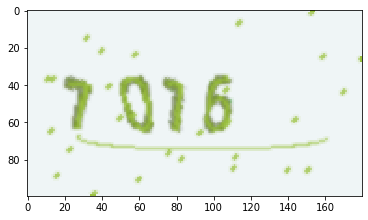

pred: 4376
true: 4376


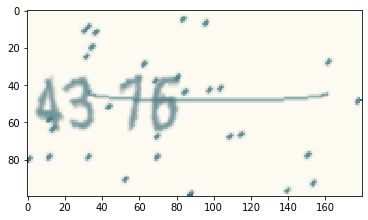

pred: 4227
true: 4217


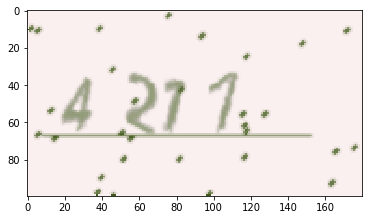

pred: 0200
true: 0200


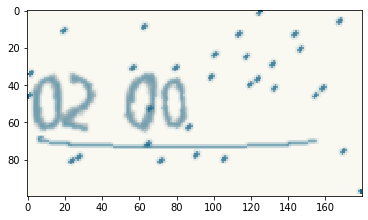

pred: 2124
true: 2124


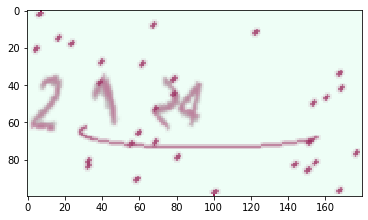

pred: 6914
true: 6914


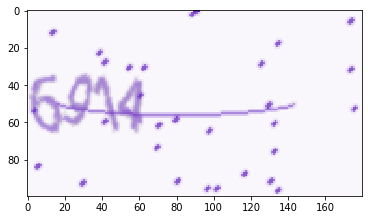

In [0]:
#Step4 Apply the model and show results

model_path = './checkpoints/model.pth'

source = [str(i) for i in range(0, 10)]
alphabet = ''.join(source)

def predict(img_dir='./captcha_torch/data/test'):
    transforms = Compose([ToTensor()])
    dataset = CaptchaData(img_dir, transform=transforms)
    cnn = CNN()
    if torch.cuda.is_available():
        cnn = cnn.cuda()
    cnn.eval()
    cnn.load_state_dict(torch.load(model_path))
    
    for k, (img, target) in enumerate(dataset):
        img = img.view(1, 3, 100, 180).cuda()
        target = target.view(1, 4*10).cuda()
        output = cnn(img)
        
        output = output.view(-1, 10)
        target = target.view(-1, 10)
        output = nn.functional.softmax(output, dim=1)
        output = torch.argmax(output, dim=1)
        target = torch.argmax(target, dim=1)
        output = output.view(-1, 4)[0]
        target = target.view(-1, 4)[0]
        
        print('pred: '+''.join([alphabet[i] for i in output.cpu().numpy()]))
        print('true: '+ ''.join([alphabet[i] for i in target.cpu().numpy()]))
        
        plt.imshow(img.permute((0, 2, 3, 1))[0].cpu().numpy())
        plt.show()
        
        if k >= 40: break
        

predict()